accept_rate = 0.8384
posterior_mean = 0.9003570644424751
posterior_median = 0.925930900872663
95% CI = (0.6641207095375291, 0.9976748265342893)
P(p>0.5) = 0.9977272727272727
P(p>0.8) = 0.8681272727272727


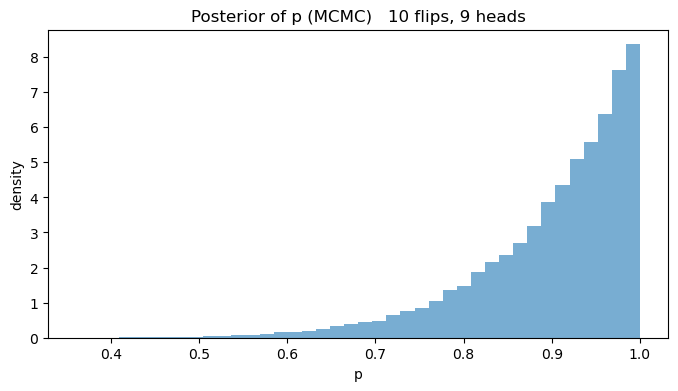

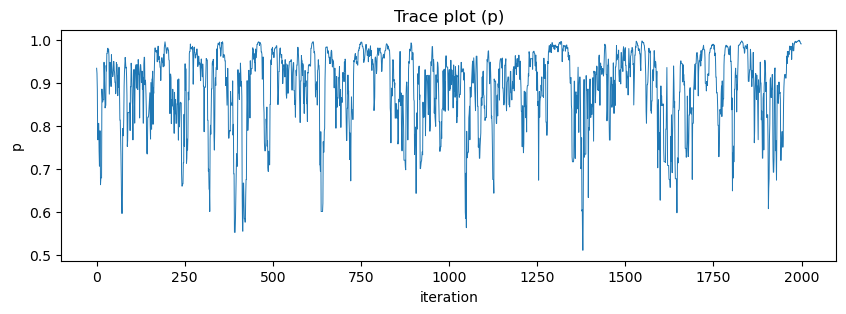

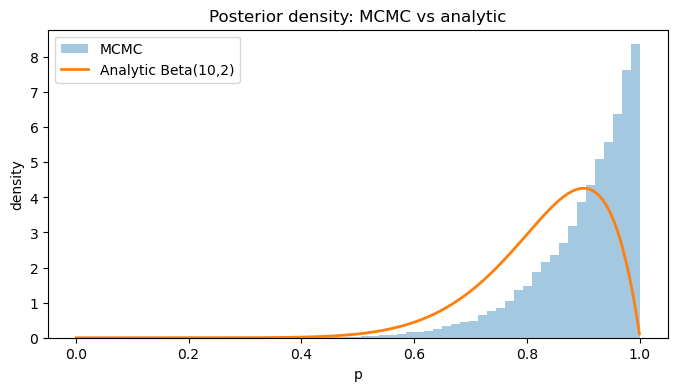

In [2]:
import math, random
import numpy as np
import matplotlib.pyplot as plt

# 観測
n = 10
y = 9

# 事前 Beta(a,b)（一様）
a0, b0 = 1.0, 1.0

def beta_func(a: float, b: float) -> float:
    """B(a,b) = Γ(a)Γ(b)/Γ(a+b) を lgamma で安定計算"""
    return math.exp(math.lgamma(a) + math.lgamma(b) - math.lgamma(a + b))

def log_posterior(p: float) -> float:
    """log posterior ∝ log prior + log likelihood（定数は省略）"""
    if p <= 0.0 or p >= 1.0:
        return -1e300
    lp = (a0 - 1.0) * math.log(p) + (b0 - 1.0) * math.log(1.0 - p)
    ll = y * math.log(p) + (n - y) * math.log(1.0 - p)
    return lp + ll

def sigmoid(z: float) -> float:
    return 1.0 / (1.0 + math.exp(-z))

# MCMC設定（MH：logit空間でランダムウォーク）
T = 60000
burn = 5000
step = 0.6

z = 0.0              # p=0.5
p = sigmoid(z)
cur = log_posterior(p)

samples = []
accept = 0

for t in range(T):
    z_prop = z + random.gauss(0.0, step)
    p_prop = sigmoid(z_prop)
    prop = log_posterior(p_prop)

    # 対称提案なので事後差のみ
    if math.log(random.random()) < (prop - cur):
        z, p, cur = z_prop, p_prop, prop
        accept += 1

    if t >= burn:
        samples.append(p)

samples = np.array(samples)
acc_rate = accept / T

# 代表統計
mean = float(samples.mean())
q025, q50, q975 = [float(x) for x in np.quantile(samples, [0.025, 0.5, 0.975])]
p_gt_05 = float((samples > 0.5).mean())
p_gt_08 = float((samples > 0.8).mean())

print("accept_rate =", acc_rate)
print("posterior_mean =", mean)
print("posterior_median =", q50)
print("95% CI =", (q025, q975))
print("P(p>0.5) =", p_gt_05)
print("P(p>0.8) =", p_gt_08)

# -----------------------
# プロット
# -----------------------

# 1) 事後分布ヒストグラム（MCMC）
plt.figure(figsize=(8,4))
plt.hist(samples, bins=40, density=True, alpha=0.6)
plt.title("Posterior of p (MCMC)   10 flips, 9 heads")
plt.xlabel("p")
plt.ylabel("density")
plt.show()

# 2) トレースプロット（先頭2000点）
plt.figure(figsize=(10,3))
plt.plot(samples[:2000], linewidth=0.7)
plt.title("Trace plot (p)")
plt.xlabel("iteration")
plt.ylabel("p")
plt.show()

# 3) 解析解 Beta(a0+y, b0+n-y) と比較
a_post = a0 + y
b_post = b0 + (n - y)

p_grid = np.linspace(0.001, 0.999, 500)
beta_norm = beta_func(a_post, b_post)  # B(a,b)
beta_density = (p_grid**(a_post - 1.0)) * ((1.0 - p_grid)**(b_post - 1.0)) / beta_norm

plt.figure(figsize=(8,4))
plt.hist(samples, bins=40, density=True, alpha=0.4, label="MCMC")
plt.plot(p_grid, beta_density, linewidth=2, label=f"Analytic Beta({int(a_post)},{int(b_post)})")
plt.title("Posterior density: MCMC vs analytic")
plt.xlabel("p")
plt.ylabel("density")
plt.legend()
plt.show()
